
# Training, validating and testing YOLOv10 Models on the Pleiades Aircraft Dataset

This notebook demonstrates how to use YOLOv10 to train aircraft object detection model on the Pleiades dataset using K-fold validation.
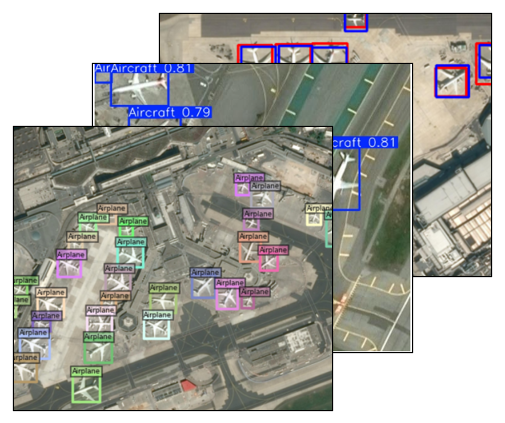

### Steps Included in this Notebook:
1. **Install Required Libraries**: Automatically installs the YOLOv10 library and dependencies.
2. **Prepare Dataset**: Converts and prepares the dataset for training and validation using K-fold splitting.
3. **Train YOLOv10 Models**: Trains YOLOv10 models for each fold and saves the best model weights for each fold.
4. **Evaluate Performance**: Calculates metrics like Precision, Recall, F1-Score, and mAP for each fold and displays the averages.
5. **Visualize Predictions**: Displays sample predictions from the trained model.

---


##Some imports

In [ ]:
import os
import numpy as np
import pandas as pd
import ast
import PIL
from tqdm.auto import tqdm
import shutil as sh
from pathlib import Path
import random
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
import shutil
import re
import time

# Mounting Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Install Ultralytics Library


In [ ]:
!pip install ultralytics
from IPython import display
from ultralytics import YOLO

display.clear_output()
!yolo checks

# Function to remove existing directories


In [ ]:
def remove_directories(directories):
    for _, folder in directories.items():
        if folder.exists() and folder.is_dir():
            shutil.rmtree(folder)
            print(f"Removed: {folder}")
        else:
            print(f"Directory not found or already deleted : {folder}")

# Update albumentations version



In [ ]:
!pip install albumentations==1.0.3
display.clear_output()
!pip show albumentations

# Datasets paths


In [ ]:
DATA_DIR = Path('/content/drive/MyDrive/Pleiades/images/Pleiades_original/images')
LABELS_DIR_SOURCE = Path('/content/drive/MyDrive/Pleiades/images/Pleiades_original/labels')
img_list = list(DATA_DIR.glob('*.jpg'))
pickone = random.choice(img_list)

In [ ]:
print(f"Found {len(img_list)} images files in {DATA_DIR}")

In [ ]:
img = PIL.Image.open(pickone)
IMAGE_HEIGHT, IMAGE_WIDTH = img.size
num_channels = len(img.mode)
print(f"Image size: {IMAGE_HEIGHT}x{IMAGE_WIDTH}")
print(f"Num channels: {num_channels}")

# Convert annotations


In [ ]:
def f(x):
    return ast.literal_eval(x.rstrip('\r\n'))

In [ ]:
df = pd.read_csv(DATA_DIR / "../annotations.csv", converters={'geometry': f, 'class': lambda o: 'Airplane'})
df.head(10)

# Calculating bounding boxes


In [ ]:
def getBounds(geometry):
    try:
        arr = np.array(geometry).T
        xmin = np.min(arr[0])
        ymin = np.min(arr[1])
        xmax = np.max(arr[0])
        ymax = np.max(arr[1])
        return (xmin, ymin, xmax, ymax)
    except:
        return np.nan

In [ ]:
df.loc[:,'bounds'] = df.loc[:,'geometry'].apply(getBounds)

# Image distribution with K-Fold (K=10)


In [ ]:
K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)
index = df['image_id'].unique()

# Tile variables


In [ ]:
TILE_WIDTH = 512
TILE_HEIGHT = 512
TILE_OVERLAP = 64
TRUNCATED_PERCENT = 0.3
_overwriteFiles = True

# Function to check whether a bounding box is inside a tile


In [ ]:
def tag_is_inside_tile(bounds, x_start, y_start, width, height, truncated_percent):
    x_min, y_min, x_max, y_max = bounds
    x_min, y_min, x_max, y_max = x_min - x_start, y_min - y_start, x_max - x_start, y_max - y_start

    if (x_min > width) or (x_max < 0.0) or (y_min > height) or (y_max < 0.0):
        return None

    x_max_trunc = min(x_max, width)
    x_min_trunc = max(x_min, 0)
    if (x_max_trunc - x_min_trunc) / (x_max - x_min) < truncated_percent:
        return None

    y_max_trunc = min(y_max, height)
    y_min_trunc = max(y_min, 0)
    if (y_max_trunc - y_min_trunc) / (y_max - y_min) < truncated_percent:
        return None

    x_center = (x_min_trunc + x_max_trunc) / 2.0 / width
    y_center = (y_min_trunc + y_max_trunc) / 2.0 / height
    x_extend = (x_max_trunc - x_min_trunc) / width
    y_extend = (y_max_trunc - y_min_trunc) / height

    return (0, x_center, y_center, x_extend, y_extend)

# Function IoU (Intersection over Union)


In [ ]:
def iou(box1, box2):

    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)

    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)

    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2g - x1g + 1) * (y2g - y1g + 1)

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou

#Function to calculate Precision, Recall and F1-Score metrics


In [ ]:
def calculate_metrics(ground_truths, predictions, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for gt, pred in zip(ground_truths, predictions):
        matched = [False] * len(gt)

        for p in pred:
            ious = [iou(p, g) for g in gt]
            max_iou = max(ious) if ious else 0

            if max_iou >= iou_threshold:
                true_positives += 1
                matched[ious.index(max_iou)] = True
            else:
                false_positives += 1

        false_negatives += matched.count(False)

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

# **Complete Pipeline for Training and Evaluating YOLO Models with K-fold Cross-Validation**

1. **Initialization of Metrics Lists**
2. **Loop over K-Fold Splits**
3. **Image Tiling**
4. **Creation of YAML Configuration File**
5. **Model Training**
6. **Validation and Metrics Calculation**
7. **Results Visualization**


In [ ]:
precision_list = []
recall_list = []
f1_score_list = []
mAP_list = []
mAP50_list = []
mAP75_list = []
# Looping to each fold
for fold, (train_indexes, val_indexes) in enumerate(kf.split(index)):
    shutil.rmtree('/content/runs/detect/', ignore_errors=True)
    print(f"Processing Fold {fold + 1}/{K}")

    train_indexes = index[train_indexes]
    val_indexes = index[val_indexes]

    print(f"Train images: {len(train_indexes)}")
    print(f"Validation images: {len(val_indexes)}")

    # Prepare train and test directories
    TILES_DIR = {'train': Path(f'/content/drive/MyDrive/train_fold{fold}/images/'),
                 'val': Path(f'/content/drive/MyDrive/val_fold{fold}/images/')}

    LABELS_DIR = {'train': Path(f'/content/drive/MyDrive/train_fold{fold}/labels/'),
                  'val': Path(f'/content/drive/MyDrive/val_fold{fold}/labels/')}

    remove_directories(TILES_DIR)
    remove_directories(LABELS_DIR)

    for _, folder in TILES_DIR.items():
        if not os.path.isdir(folder):
            os.makedirs(folder)

    for _, folder in LABELS_DIR.items():
        if not os.path.isdir(folder):
            os.makedirs(folder)

    # Save tiles and labels for train and validation
    for img_path in tqdm(img_list):
        pil_img = PIL.Image.open(img_path, mode='r')
        np_img = np.array(pil_img, dtype=np.uint8)
        img_labels = df[df["image_id"] == img_path.name]

        X_TILES = (IMAGE_WIDTH + TILE_WIDTH - TILE_OVERLAP - 1) // (TILE_WIDTH - TILE_OVERLAP)
        Y_TILES = (IMAGE_HEIGHT + TILE_HEIGHT - TILE_OVERLAP - 1) // (TILE_HEIGHT - TILE_OVERLAP)

        for x in range(X_TILES):
            for y in range(Y_TILES):
                x_end = min((x + 1) * TILE_WIDTH - TILE_OVERLAP * (x != 0), IMAGE_WIDTH)
                x_start = x_end - TILE_WIDTH
                y_end = min((y + 1) * TILE_HEIGHT - TILE_OVERLAP * (y != 0), IMAGE_HEIGHT)
                y_start = y_end - TILE_HEIGHT

                if img_path.name in train_indexes:
                    folder = 'train'
                elif img_path.name in val_indexes:
                    folder = 'val'
                else:
                    continue

                save_tile_path = TILES_DIR[folder].joinpath(img_path.stem + "_" + str(x_start) + "_" + str(y_start) + ".jpg")
                save_label_path = LABELS_DIR[folder].joinpath(img_path.stem + "_" + str(x_start) + "_" + str(y_start) + ".txt")

                if _overwriteFiles or not os.path.isfile(save_tile_path):
                    cut_tile = np.zeros(shape=(TILE_WIDTH, TILE_HEIGHT, 3), dtype=np.uint8)
                    cut_tile[0:TILE_HEIGHT, 0:TILE_WIDTH, :] = np_img[y_start:y_end, x_start:x_end, :]
                    cut_tile_img = PIL.Image.fromarray(cut_tile)
                    cut_tile_img.save(save_tile_path)

                found_tags = [
                    tag_is_inside_tile(bounds, x_start, y_start, TILE_WIDTH, TILE_HEIGHT, TRUNCATED_PERCENT)
                    for i, bounds in enumerate(img_labels['bounds'])]
                found_tags = [el for el in found_tags if el is not None]

                with open(save_label_path, 'w+') as f:
                    for tags in found_tags:
                        f.write(' '.join(str(x) for x in tags) + '\n')

    # Create a YAML configuration file for each fold
    CONFIG = f"""
    # train and val datasets (image directory or *.txt file with image paths)
    train: /content/drive/MyDrive/train_fold{fold}/
    val: /content/drive/MyDrive/val_fold{fold}/

    # number of classes
    nc: 1

    # class names
    names: ['Airplane']
    """

    with open(f"/content/drive/MyDrive/data_fold{fold}.yaml", "w") as f:
        f.write(CONFIG)


    HOME = "/content/drive/MyDrive"


    os.environ['WANDB_MODE'] = 'disabled'
    start_time=time.time()

    !yolo task=detect mode=train model=yolov10m.pt data={HOME}/data_fold{fold}.yaml epochs=12 imgsz=512 batch=2 workers=2 mosaic=0.0 flipud=0.5 scale=0.0
    # Copy the best.pt file to Google Drive for each fold
    end_time=time.time()
    print("Execution_time: "+str(end_time-start_time))
    source_path = '/content/runs/detect/train/weights/best.pt'
    destination_path = f'/content/drive/MyDrive/YOLO_Models/best_{fold}.pt'

    try:
        shutil.copy(source_path, destination_path)
        print(f"Model for fold {fold} saved successfully at {destination_path}")
    except FileNotFoundError:
        print(f"Error: best.pt file for fold {fold} not found.")



    # initializing our model
    model = YOLO("/content/runs/detect/train/weights/best.pt")


    # Validate the model
    metrics_using_YOLO = model.val(data=HOME+"/data_fold"+str(fold)+".yaml")

    #Another way to validate
    '''val_output =!yolo task=detect mode=val conf=0.5 iou=0.5 model=/content/runs/detect/train/weights/best.pt data={HOME}/data_fold{fold}.yaml imgsz=512'''

    if metrics_using_YOLO.box.mr==0.0 and metrics_using_YOLO.box.mp==0.0:
      f1_score=0.0
    else:
      f1_score=(2*metrics_using_YOLO.box.mp*metrics_using_YOLO.box.mr)/(metrics_using_YOLO.box.mp+metrics_using_YOLO.box.mr)




    # Displaying test metrics for each fold
    print("mAP50-95 for fold number "+str(fold)+":", metrics_using_YOLO.box.map)
    print("mAP50 for fold number "+str(fold)+":", metrics_using_YOLO.box.map50)
    print("mAP75 for fold number "+str(fold)+":", metrics_using_YOLO.box.map75)
    print("Precision for fold number "+str(fold)+":", metrics_using_YOLO.box.mp)
    print("Recall for fold number "+str(fold)+":", metrics_using_YOLO.box.mr)
    print("F1-score for fold number "+str(fold)+":", f1_score)




    precision_list.append(metrics_using_YOLO.box.mp)
    recall_list.append(metrics_using_YOLO.box.mr)
    f1_score_list.append(f1_score)
    mAP_list.append(metrics_using_YOLO.box.map)
    mAP50_list.append(metrics_using_YOLO.box.map50)
    mAP75_list.append(metrics_using_YOLO.box.map75)


    # Displaying predictions
    !yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.4 iou=0.5 source=/content/drive/MyDrive/val_fold{fold}/images imgsz=512 save_txt=True


    predictions = []
    for img_path in img_list:
        pred_path = f'/content/runs/detect/predict/labels/{img_path.stem}.txt'  # YOLO stores predictions as .txt files
        if os.path.exists(pred_path):
            with open(pred_path, 'r') as f:
                preds = [list(map(float, line.strip().split()[1:])) for line in f.readlines()]
                predictions.append(preds)
        else:
            predictions.append([])

    # Load ground truth
    ground_truths = []
    for img_path in img_list:
        label_path = LABELS_DIR_SOURCE / img_path.with_suffix('.txt')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                labels = [list(map(float, line.strip().split()[1:])) for line in f.readlines()]
                ground_truths.append(labels)
        else:
            ground_truths.append([])



    # Displaying predictions
    import glob
    from IPython.display import Image, display

    for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg'):
        display(Image(filename=image_path, width=1024))
        print("\n")

# Calculation of metrics means after all folds


In [ ]:
mean_precision = np.mean(precision_list)
mean_recall = np.mean(recall_list)
mean_f1_score = np.mean(f1_score_list)
mean_mAP = np.mean(mAP_list)
mean_mAP50 = np.mean(mAP50_list)
mean_mAP75 = np.mean(mAP75_list)

# Displaying overall metrics


In [ ]:
print("\nOverall metrics on all fold: ")
print(f"Mean precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
print(f"Mean F1-Score: {mean_f1_score:.4f}")
print(f"Mean mAP50: {mean_mAP50:.4f}")
print(f"Mean mAP75: {mean_mAP75:.4f}")
print(f"Mean mAP: {mean_mAP:.4f}")